In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imshow

from skimage.measure import label

import deepcell.datasets
from deepcell import metrics

Using TensorFlow backend.


# Load data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

6370107392/6370099814 [==============================] - 125s 0us/step
X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


# Instantiate model from saved weights

First instantiate a model from the deepcell `model_zoo`.

In [3]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=61,
    n_skips=3,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

Compile the model and load weights from a previously trained model.

In [4]:
from tensorflow.keras.optimizers import SGD

fgbg_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
fgbg_model.load_weights('/models/conv_fgbg_model.h5')

# Generate predictions from test data

In [5]:
predict = fgbg_model.predict(X_test)[-1]

Use `skimage.measure.label` to identify discrete objects (nuclei) in the prediction data.

In [25]:
predict_lbl = label((predict[:,:,:,1]>0.5).astype('int'))

Visualize the image at each stage in processing.

1256
Number of cells predicted: 9
Number of true cells: 10
True positives: 6, Accuracy: 0.6
False positives: 1
False negatives: 0
Merges: 2
Splits: 0
SEG: 0.8076


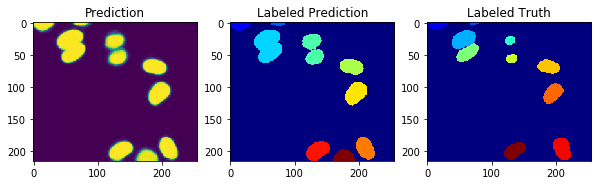

In [196]:
# Select a random sample to view
i = np.random.randint(0,high=1440)
print(i)

y_true = label(y_test[i:i+1,:,:,0].astype('int'))
y_pred = label(predict_lbl[i:i+1])

fig,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(predict[i,:,:,1])
ax[0].set_title('Prediction')
# Repeat labeling to get number assignments in range for this particular frame
ax[1].imshow(y_pred[0],cmap='jet')
ax[1].set_title('Labeled Prediction')
ax[2].imshow(y_true[0],cmap='jet')
ax[2].set_title('Labeled Truth')

m = metrics.Metrics('singleton',seg=True)
m.calc_object_stats(y_true,y_pred)

# Run metrics on complete test set

In [195]:
%%time
m = metrics.Metrics('fgbg',seg=True)

y_true_lbl = y_test[:,:,:,0].astype('int')
y_pred_lbl = predict_lbl

m.calc_object_stats(y_true_lbl,y_pred_lbl)

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:609: RuntimeWarning: Mean of empty slice
  self.seg_score = np.nanmean(iou_mask[self.true_pos_ind[0], self.true_pos_ind[1]])


Number of cells predicted: 9917
Number of true cells: 10338
True positives: 8396, Accuracy: 0.81
False positives: 582
False negatives: 364
Merges: 681
Splits: 1
SEG: 0.8439
CPU times: user 1min, sys: 272 ms, total: 1min 1s
Wall time: 1min 1s


Note: pixel based statistics are also available from `m.all_pixel_stats`, but it requires that the ground truth annotation be transformed to match the features output by the model prediction.

Additionally, the final metric report can be saved using `m.save_to_json(m.output)` after object and/or pixel statistics have been generated.